In [1]:
# importando as bibliotecas
from pyspark.sql import Row
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spSession = SparkSession.builder.master("local").appName("ml-telecom").getOrCreate()

In [3]:
# Carregando os dados e gerando os RDD's
treinoRDD = sc.textFile("projeto4_telecom_treino.csv")
testeRDD = sc.textFile("projeto4_telecom_teste.csv")

In [4]:
# Colocando os RDDs em cache
treinoRDD.cache()
testeRDD.cache()

projeto4_telecom_teste.csv MapPartitionsRDD[3] at textFile at NativeMethodAccessorImpl.java:0

In [5]:
# Removendo os cabeçalhos do arquivo
treinoRDD2 = treinoRDD.filter(lambda x: "account_length" not in x)
testeRDD2 = testeRDD.filter(lambda x: "account_length" not in x)

In [6]:
# Função para gerar RDD com linhas usando a função Row
def geraLinha(inputStr) :
    attList = inputStr.split(",")
    
    #convertendo a variavel target para numerica
    if(attList[20].replace('"', '')=="no"):
        target = 0
    else:
        target = 1
       
    # Criando a linha, limpando e convertendo os dados de string para float
    linha = Row(id = attList[0].replace('"', ''), state = attList[1].replace('"', ''), account_length = float(attList[2]), 
                area_code = attList[3].replace('"', ''), international_plan = attList[4].replace('"', ''), 
                voice_mail_plan = attList[5].replace('"', ''), number_vmail_messages = float(attList[6]), 
                total_day_minutes = float(attList[7]), total_day_calls = float(attList[8]), 
                total_day_charge = float(attList[9]), total_eve_minutes = float(attList[10]), 
                total_eve_calls = float(attList[11]), total_eve_charge = float(attList[12]), 
                total_night_minutes = float(attList[13]), total_night_calls = float(attList[14]), 
                total_night_charge = float(attList[15]), total_intl_minutes = float(attList[16]), 
                total_intl_calls = float(attList[17]), total_intl_charge = float(attList[18]), 
                number_customer_service_calls = float(attList[19]), churn = target) 
    return linha

In [7]:
#cria RDD's com linhas 
treinoRDD3 = treinoRDD2.map(geraLinha)
testeRDD3 = testeRDD2.map(geraLinha)

In [8]:
# Cria os Dataframes de treino e teste
treinoDF = spSession.createDataFrame(treinoRDD3)
testeDF = spSession.createDataFrame(testeRDD3)

In [9]:
#criando novos atributos
treinoDF = treinoDF.withColumn("md_day_minute", F.col("total_day_minutes")/F.col("total_day_calls"))
treinoDF = treinoDF.withColumn("md_eve_minute", F.col("total_eve_minutes")/F.col("total_eve_calls"))
treinoDF = treinoDF.withColumn("md_night_minute", F.col("total_night_minutes")/F.col("total_night_calls"))
treinoDF = treinoDF.withColumn("md_intl_minute", F.col("total_intl_minutes")/F.col("total_intl_calls"))
treinoDF = treinoDF.withColumn("total_ligacoes", F.col("total_day_calls") + F.col("total_eve_calls") + F.col("total_night_calls") + F.col("total_intl_calls"))
treinoDF = treinoDF.withColumn("total_cobrado", F.col("total_day_charge") + F.col("total_eve_charge") + F.col("total_night_charge") + F.col("total_intl_charge"))
testeDF = testeDF.withColumn("md_day_minute", F.col("total_day_minutes")/F.col("total_day_calls"))
testeDF = testeDF.withColumn("md_eve_minute", F.col("total_eve_minutes")/F.col("total_eve_calls"))
testeDF = testeDF.withColumn("md_night_minute", F.col("total_night_minutes")/F.col("total_night_calls"))
testeDF = testeDF.withColumn("md_intl_minute", F.col("total_intl_minutes")/F.col("total_intl_calls"))
testeDF = testeDF.withColumn("total_ligacoes", F.col("total_day_calls") + F.col("total_eve_calls") + F.col("total_night_calls") + F.col("total_intl_calls"))
testeDF = testeDF.withColumn("total_cobrado", F.col("total_day_charge") + F.col("total_eve_charge") + F.col("total_night_charge") + F.col("total_intl_charge"))

In [10]:
#prenhendo os valores missing gerados pelos cálculos
treinoDF = treinoDF.na.fill(0,["md_day_minute","md_eve_minute","md_night_minute","md_intl_minute"])
testeDF = testeDF.na.fill(0,["md_day_minute","md_eve_minute","md_night_minute","md_intl_minute"])

In [11]:
#excluindo os atributos que possuem alta correlação
treinoDF = treinoDF.drop("total_day_minutes", "total_eve_minutes", "total_night_minutes", "total_intl_minutes")
testeDF = testeDF.drop("total_day_minutes", "total_eve_minutes", "total_night_minutes", "total_intl_minutes")

In [12]:
#criando RDD's temporarios para os dados, caso seja necessário voltar a essa etapa do processo
treinoRDD_tmp  = treinoDF.rdd
testeRDD_tmp  = testeDF.rdd

In [13]:
# Sumarizando os dados e extraindo o minimo e maximo de cada atributo para normalização
estats = treinoDF.select("account_length","number_customer_service_calls","number_vmail_messages","total_day_calls","total_day_charge","total_eve_calls","total_eve_charge","total_intl_calls","total_intl_charge","total_night_calls","total_night_charge","churn", "total_ligacoes", "total_cobrado","md_day_minute","md_eve_minute","md_night_minute","md_intl_minute").describe().toPandas()
minimo = estats.iloc[3,1:19].values.tolist()
maximo = estats.iloc[4,1:19].values.tolist()

In [14]:
# Colocando  minimo e maximo em variáves do tipo Broadcast
bc_minimo = sc.broadcast(minimo)
bc_maximo = sc.broadcast(maximo)

In [15]:
#funcao para normalização dos dados
def normaliza(inRow) :
    global bc_minimo
    global bc_maximo
    
    minArray = bc_minimo.value
    maxArray = bc_maximo.value
    
    rowDict = inRow.asDict()
    retArray = {}
    
    i=0
    for k in rowDict:
        if(k=="churn"):
            retArray[k] = float(inRow[i])
        else:
            retArray[k] = (float(inRow[i]) - float(minArray[i])) / (float(maxArray[i])-float(minArray[i]) )
        i=i+1
    return Row(**retArray)

In [16]:
#aplicando normalização
treinoRDD4 = treinoDF.select("account_length","number_customer_service_calls","number_vmail_messages","total_day_calls","total_day_charge","total_eve_calls","total_eve_charge","total_intl_calls","total_intl_charge","total_night_calls","total_night_charge","churn", "total_ligacoes", "total_cobrado","md_day_minute","md_eve_minute","md_night_minute","md_intl_minute").rdd.map(normaliza)
treinoDF = spSession.createDataFrame(treinoRDD4)
testeRDD4 = testeDF.select("account_length","number_customer_service_calls","number_vmail_messages","total_day_calls","total_day_charge","total_eve_calls","total_eve_charge","total_intl_calls","total_intl_charge","total_night_calls","total_night_charge","churn", "total_ligacoes", "total_cobrado","md_day_minute","md_eve_minute","md_night_minute","md_intl_minute").rdd.map(normaliza)
testeDF = spSession.createDataFrame(testeRDD4)

In [17]:
#funcão de SMOTE para os dados de treino, esta função irá balancear os dados de treino, pois a variável target (churn), possuí
#mais valores 0 que 1, sendo assim, serão criados dados sintéticos com o valor da variável igual a 1, buscando minimizar o 
#erro principalmente nas previsões dos registros que contém target=1 (minimizar erro tipo 2)
import random
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler

#funcao que vetoriza os dados, criando um atributo com um vetor contendo as variáveis preditoras e outro atributo 
#com a variável target, modelo de dados utilizado pelos algoritmos de machine learning do spark
def vectorizerFunction(dataInput, TargetFieldName):
    if(dataInput.select(TargetFieldName).distinct().count() != 2):
        raise ValueError("Target field must have only 2 distinct classes")
    columnNames = list(dataInput.columns)
    columnNames.remove(TargetFieldName)
    dataInput = dataInput.select((','.join(columnNames)+','+TargetFieldName).split(','))
    assembler=VectorAssembler(inputCols = columnNames, outputCol = 'features')
    pos_vectorized = assembler.transform(dataInput)
    vectorized = pos_vectorized.select('features',TargetFieldName).withColumn('label',pos_vectorized[TargetFieldName]).drop(TargetFieldName)
    return vectorized

#função que cria os dados sintéticos, balanceando os dados de treino na variável target
def SmoteSampling(vectorized, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 200, percentageUnder = 100):
    if(percentageUnder > 100|percentageUnder < 10):
        raise ValueError("Percentage Under must be in range 10 - 100");
    if(percentageOver < 100):
        raise ValueError("Percentage Over must be in at least 100");
    dataInput_min = vectorized[vectorized['label'] == minorityClass]
    dataInput_maj = vectorized[vectorized['label'] == majorityClass]
    feature = dataInput_min.select('features')
    feature = feature.rdd
    feature = feature.map(lambda x: x[0])
    feature = feature.collect()
    feature = np.asarray(feature)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto').fit(feature)
    neighbours =  nbrs.kneighbors(feature)
    gap = neighbours[0]
    neighbours = neighbours[1]
    min_rdd = dataInput_min.drop('label').rdd
    pos_rddArray = min_rdd.map(lambda x : list(x))
    pos_ListArray = pos_rddArray.collect()
    min_Array = list(pos_ListArray)
    newRows = []
    nt = len(min_Array)
    nexs = percentageOver/100
    for i in range(nt):
        for j in range(int(nexs)):
            neigh = random.randint(1,k)
            difs = min_Array[neigh][0] - min_Array[i][0]
            newRec = (min_Array[i][0]+random.random()*difs)
            newRows.insert(0,(newRec))
    newData_rdd = sc.parallelize(newRows)
    newData_rdd_new = newData_rdd.map(lambda x: Row(features = x, label = 1))
    new_data = newData_rdd_new.toDF()
    new_data_minor = dataInput_min.unionAll(new_data)
    new_data_major = dataInput_maj.sample(False, (float(percentageUnder)/float(100)))
    return new_data_major.unionAll(new_data_minor)

In [18]:
#aplicando a técnica de SMOTE e vetorização na base de treino
treinoDF = SmoteSampling(vectorizerFunction(treinoDF.select("account_length","number_customer_service_calls","number_vmail_messages","total_day_calls","total_day_charge","total_eve_calls","total_eve_charge","total_intl_calls","total_intl_charge","total_night_calls","total_night_charge","churn", "total_ligacoes", "total_cobrado","md_day_minute","md_eve_minute","md_night_minute","md_intl_minute"), "churn"), percentageOver=400)

In [19]:
#vetorizando os dados de teste (nos dados de teste não há necessidade de criar dados sintéticos, pois serão usados apenas
#para testar a acurácia do modelo já teinado)
testeDF = vectorizerFunction(testeDF.select("account_length","number_customer_service_calls","number_vmail_messages","total_day_calls","total_day_charge","total_eve_calls","total_eve_charge","total_intl_calls","total_intl_charge","total_night_calls","total_night_charge","churn", "total_ligacoes", "total_cobrado","md_day_minute","md_eve_minute","md_night_minute","md_intl_minute"), "churn")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FEEF82CDA0>]],
      dtype=object)

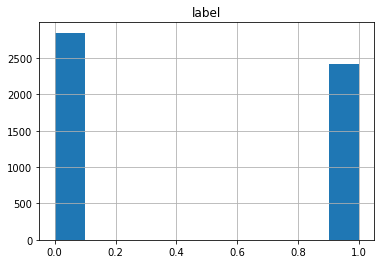

In [20]:
#verificando o balanceamento da variável target após SMOTE
treinoDF.select("label").toPandas().hist()

Distribuição da variável target está mais equilibrada

### Aplicação de Machine Learning
Serão testados alguns algoritmos de machine learning para o problema de classificação, pelo fato dos dados serem desbalanceados, a acurácia dos algoritmos será medida a partir da area under the ROC curve. O objetivo é um score mínimo de 0.80.

In [21]:
#aplicando regressão logistica na base de treino e testando o modelo
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

#treinando o modelo
lr = LogisticRegression()
lr_mdl = lr.fit(treinoDF)

#previsão dados de teste
pred = lr_mdl.transform(testeDF)

#avaliando a performance do modelo
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
evaluator.evaluate(pred)   

0.7437351499851506

In [22]:
#criando uma base com as variáveis mais importantes
from pyspark.ml.feature import ChiSqSelector

selector = ChiSqSelector(numTopFeatures=10, outputCol="bst_features")
selector_mdl = selector.fit(treinoDF)
result = selector_mdl.transform(treinoDF)

In [23]:
#treinando o modelo com as variáveis mais importantes
lr = LogisticRegression(featuresCol='bst_features')
lr_mdl = lr.fit(result)

#previsão dados de teste
pred = lr_mdl.transform(selector_mdl.transform(testeDF))

#avaliando a performance do modelo
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
evaluator.evaluate(pred) 

0.7333061083061083

A seleção de variáveis piorou o resultado

In [24]:
#treinando o modelo com outros parâmetros
lr = LogisticRegression(regParam=0.2, elasticNetParam=0.5)
lr_mdl = lr.fit(treinoDF)

#previsão dados de teste
pred = lr_mdl.transform(testeDF)

#avaliando a performance do modelo
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
evaluator.evaluate(pred)   

0.7175449831699827

Aumentar os parâmetros de regularização e elasticNet também fez com que a performance do modelo piorasse

In [25]:
#testando o algoritmo decision tree
from pyspark.ml.classification import DecisionTreeClassifier

#treinando o modelo
dt = DecisionTreeClassifier()
dt_mdl = dt.fit(treinoDF)

#prevendo os dados de teste
pred = dt_mdl.transform(testeDF)

#avaliando a performance do modelo
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
evaluator.evaluate(pred)   

0.7500572344322344

O algoritmo de decision tree teve performance melhor que regressão logistica

In [26]:
#testando o algoritmo random forest
from pyspark.ml.classification import RandomForestClassifier

#treinando o modelo
rf = RandomForestClassifier()
rf_mdl = rf.fit(treinoDF)

#prevendo os dados de teste
pred = rf_mdl.transform(testeDF)

#avaliando a performance do modelo
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
evaluator.evaluate(pred)   

0.8274289055539054

Random Forest teve a melhor perfomance até o momento, apesar do objetivo de perfomance ter sido superado por esse algoritmo, ainda serão testados outros métodos buscando uma melhor acurácia.

In [27]:
#testando o algortimo NaiveBayes
from pyspark.ml.classification import NaiveBayes

#treinando o modelo
nb = NaiveBayes()
nb_mdl = nb.fit(treinoDF)

#previsão dados de teste
pred = nb_mdl.transform(testeDF)

#avaliando a performance do modelo
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
evaluator.evaluate(pred)   

0.36215473715473734

Algoritmo Naive Bayes não apresentou uma boa acurácia. Por apresentar a melhor acurácia entre os algoritmos testados, os próximos testes serão feitos utilizando o algoritmo random forest, primeiramente serão feitas modificações na base de treinos, buscando aquelas que apresentarem a melhor performance, após isso, com o modelo de dados que melhor performou, serão ajustados os hyperparâmetros do algoritmo.

In [28]:
#testando os dados sem SMOTE

#usando os RRD's 4 (antes da aplicação do SMOTE)
treinoDF = spSession.createDataFrame(treinoRDD4)
testeDF = spSession.createDataFrame(testeRDD4)

#vetorizando os dados
treinoDF = vectorizerFunction(treinoDF.select("account_length","number_customer_service_calls","number_vmail_messages","total_day_calls","total_day_charge","total_eve_calls","total_eve_charge","total_intl_calls","total_intl_charge","total_night_calls","total_night_charge","churn", "total_ligacoes", "total_cobrado","md_day_minute","md_eve_minute","md_night_minute","md_intl_minute"), "churn")
testeDF = vectorizerFunction(testeDF.select("account_length","number_customer_service_calls","number_vmail_messages","total_day_calls","total_day_charge","total_eve_calls","total_eve_charge","total_intl_calls","total_intl_charge","total_night_calls","total_night_charge","churn", "total_ligacoes", "total_cobrado","md_day_minute","md_eve_minute","md_night_minute","md_intl_minute"), "churn")

In [29]:
#aplicando o algoritmo

#treinando o modelo
rf = RandomForestClassifier()
rf_mdl = rf.fit(treinoDF)

#prevendo os dados de teste
pred = rf_mdl.transform(testeDF)

#avaliando a performance do modelo
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
evaluator.evaluate(pred)   

0.887009949509952

Modelo apresentou uma boa melhora sem o uso de SMOTE

In [30]:
#testando os dados sem normalização

#usando os RDDs temporarios (antes da aplicação da normalização)
treinoDF = spSession.createDataFrame(treinoRDD_tmp)
testeDF = spSession.createDataFrame(testeRDD_tmp)

#vetorizando os dados
treinoDF = vectorizerFunction(treinoDF.select("account_length","number_customer_service_calls","number_vmail_messages","total_day_calls","total_day_charge","total_eve_calls","total_eve_charge","total_intl_calls","total_intl_charge","total_night_calls","total_night_charge","churn", "total_ligacoes", "total_cobrado","md_day_minute","md_eve_minute","md_night_minute","md_intl_minute"), "churn")
testeDF = vectorizerFunction(testeDF.select("account_length","number_customer_service_calls","number_vmail_messages","total_day_calls","total_day_charge","total_eve_calls","total_eve_charge","total_intl_calls","total_intl_charge","total_night_calls","total_night_charge","churn", "total_ligacoes", "total_cobrado","md_day_minute","md_eve_minute","md_night_minute","md_intl_minute"), "churn")

In [31]:
#aplicando o algoritmo

#treinando o modelo
rf = RandomForestClassifier()
rf_mdl = rf.fit(treinoDF)

#prevendo os dados de teste
pred = rf_mdl.transform(testeDF)

#avaliando a performance do modelo
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
evaluator.evaluate(pred)   

0.8870099495099523

Não houve diferenças no score utilizando os dados sem normalização

In [32]:
#aplicando redução de dimensionalidade com PCA
from pyspark.ml.feature import PCA

pca = PCA(k = 6, inputCol = "features", outputCol = "pcaFeatures")
pcaModel = pca.fit(treinoDF)
pcaResult = pcaModel.transform(treinoDF).select("label","pcaFeatures")
pcaTest =  pcaModel.transform(testeDF).select("label","pcaFeatures")

In [33]:
#aplicando o algoritmo

#treinando o modelo
rf = RandomForestClassifier(featuresCol = "pcaFeatures")
rf_mdl = rf.fit(pcaResult)

#prevendo os dados de teste
pred = rf_mdl.transform(pcaTest)

#avaliando a performance do modelo
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
evaluator.evaluate(pred)   

0.750146953271954

Reduzir a dimensionalidade não melhorou a acurácia do modelo, pelo contrário, apresentou um score abaixo do anterior

In [34]:
#testando outros parâmetros no algoritmo, o modelo será treinado com combinações de hyperparâmetros
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

#criando o estimador
rf = RandomForestClassifier()

#criando o grid de hyperparâmetros
paramGrid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [5, 8, 12, 15])\
    .addGrid(rf.minInstancesPerNode, [1, 3, 5, 7])\
    .addGrid(rf.numTrees, [30, 50, 70, 100])\
    .addGrid(rf.subsamplingRate, [0.3, 0.5, 0.8, 1])\
    .build()
    
#treinando o modelo usando as combinações de hyperparâmetros, 80% dos dados serão usados para treino e 20% para testes
tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           trainRatio=0.8)

tv_model = tvs.fit(treinoDF)

In [35]:
#prevendo os dados de teste
pred = tv_model.transform(testeDF)

#avaliando a performance do modelo
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
evaluator.evaluate(pred) 

0.8943019255519248

Este modelo até então teve o melhor resultado de todos os testes

In [36]:
#analisando a importancia dos atributos do melhor modelo
tv_model.bestModel.featureImportances

SparseVector(17, {0: 0.0087, 1: 0.1849, 2: 0.1073, 3: 0.0087, 4: 0.1331, 5: 0.0072, 6: 0.0241, 7: 0.0076, 8: 0.0191, 9: 0.0071, 10: 0.0068, 11: 0.0049, 12: 0.4101, 13: 0.0246, 14: 0.0127, 15: 0.0101, 16: 0.0229})

In [37]:
#obtendo os parametros do melhor modelo
print("maxDepth: " + str(tv_model.bestModel._java_obj.getMaxDepth()))
print("minInstancesPerNode: " + str(tv_model.bestModel._java_obj.getMinInstancesPerNode()))
print("numTrees: "  + str(tv_model.bestModel._java_obj.getNumTrees()))
print("subsamplingRate: "  + str(tv_model.bestModel._java_obj.getSubsamplingRate()))

maxDepth: 5
minInstancesPerNode: 7
numTrees: 50
subsamplingRate: 0.8


In [38]:
#criando a base de dados com as melhores features
#os atributos mais importantes são os seguintes (por indice) 12,1,4,2,13,6,16,8,14,15, também será incluido o atributo 17 ma 
#lista (variável target), criando a lista de atributos na ordem utilizada na transformação:
list_attr = np.array(["account_length","number_customer_service_calls","number_vmail_messages","total_day_calls","total_day_charge","total_eve_calls","total_eve_charge","total_intl_calls","total_intl_charge","total_night_calls","total_night_charge","total_ligacoes", "total_cobrado","md_day_minute","md_eve_minute","md_night_minute","md_intl_minute","churn"])

#recriando os dataframes originais
new_treinoDF = spSession.createDataFrame(treinoRDD_tmp)
new_testeDF = spSession.createDataFrame(testeRDD_tmp)

#vetorizando os dados
new_treinoDF = vectorizerFunction(new_treinoDF.select(list(list_attr[[12,1,4,2,13,6,16,8,14,15,17]])), "churn")
new_testeDF = vectorizerFunction(new_testeDF.select(list(list_attr[[12,1,4,2,13,6,16,8,14,15,17]])), "churn")

In [39]:
#aplicando o algoritmo

#treinando o modelo
rf = RandomForestClassifier(labelCol="label", maxDepth=5, minInstancesPerNode=7, numTrees=50, subsamplingRate=0.8)
rf_mdl = rf.fit(new_treinoDF)

#prevendo os dados de teste
pred = rf_mdl.transform(new_testeDF)

#avaliando a performance do modelo
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
evaluator.evaluate(pred)   

0.8889033264033266

A seleção de variáveis piorou o modelo, portanto, o melhor modelo entre todos foi o random forest com os seguintes parâmetros: maxDepth: 5, minInstancesPerNode: 7, numTrees: 50, subsamplingRate: 0.8.

In [40]:
#aplicando as predições com o melhor modelo nos dados de teste
pred = tv_model.transform(testeDF)

In [42]:
#avaliando a matriz de confusão do modelo
pred.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   84|
|    0|       1.0|    8|
|    0|       0.0| 1435|
|    1|       1.0|  140|
+-----+----------+-----+



92 previsões erradas, 1.575 previsões corretas (94,48% de acerto)

In [43]:
#funcao para extrair das previsões o valor previsto e a probabilidade de isso ocorrer
def probaPrediction(rw):
    pred = rw["prediction"]
    proba = rw["probability"].values.item(int(pred))
    return Row(predicao = pred, probabilidade = proba)

In [44]:
#criando um dataframe com as previsoes e as probabilidades
predDF = spSession.createDataFrame(pred.rdd.map(probaPrediction))

In [45]:
#criando o data frame com os dados de teste
new_testeDF = spSession.createDataFrame(testeRDD3)

#será criado um id usando a função monotonically_increasing_id para a junção dos dois dataframes, porém essa função não gera 
#os dados de forma sequencial, portanto o id original será mantido, renomeado e após a junção das duas bases essa coluna 
#será novamente renomeada para o nome original
new_testeDF = new_testeDF.withColumnRenamed("id","id_old")
new_testeDF = new_testeDF.withColumn("idj", F.monotonically_increasing_id())

#colocando uma coluna ID nos dados de previsao para juntá-los
predDF = predDF.withColumn("idj", F.monotonically_increasing_id())

#juntando com os dados de treino com as previsões
testeDF_final = new_testeDF.join(predDF, on="idj")
#reordenando os dados
testeDF_final = testeDF_final.orderBy("idj")
#excluindo a coluna utilizada para junção
testeDF_final = testeDF_final.drop("idj","id")
#retornando a coluna id original
testeDF_final = testeDF_final.withColumnRenamed("id_old","id")

In [46]:
#salvando os dados com as previsões em arquivo
testeDF_final.toPandas().to_csv('previsoes.csv', index = False)

O arquivo previsoes.csv contem os dados originais de treino, as previsões e a probabilidade de acerto do modelo para cada previsão, o modelo aplicado acertou 94,48% das previsões, com score de area Under ROC de 0.8943.